In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from math import inf
from collections import deque
from matplotlib.patches import Arc
from matplotlib.patches import PathPatch
from matplotlib.path import Path

In [ ]:
def sigmoid(x, beta=1):
    return 1 / (1 + np.exp(-beta * x))

def draw_curve(p1, p2, beta=1):
    x_values = np.linspace(-5, 5, 100)
    y_values = sigmoid(x_values, beta)
    x_adj = (x_values - x_values.min()) / (x_values.max() - x_values.min())
    x_adj = x_adj * (p2[0] - p1[0]) + p1[0]
    y_adj = (y_values - y_values.min()) / (y_values.max() - y_values.min())
    y_adj = y_adj * (p2[1] - p1[1]) + p1[1]
    return x_adj, y_adj

In [ ]:
class Diagram():
    def __init__(self, pairings, factor=0):
        self.row0 = []
        self.row1 = []
        self.rows = []
        self.factor = factor
        self.connections = dict()

        for pair in pairings:
            n, m = pair
            self.connections[n] = m
            self.connections[m] = n

        self.top = 0
        self.bottom = 0
        
        for pair in pairings:
            n, m = pair
            if n[1] == 0:
                self.bottom = max(self.bottom, n[0])
            else:
                self.top = max(self.top, n[0])

            if m[1] == 0:
                self.bottom = max(self.bottom, m[0])
            else:
                self.top = max(self.top, m[0])

            if n[1] ==m[1] == 0:
                self.row0.append(tuple(sorted(pair, key=lambda x: x[0])))
            elif n[1] ==m[1] == 1:
                self.row1.append(tuple(sorted(pair, key=lambda x: x[0])))
            else:
                pp = tuple(sorted(pair, key = lambda x: x[1], reverse=True))
                self.rows.append(pair)
        self.row0.sort(key = lambda x: x[0][0])
        self.row1.sort(key = lambda x: x[0][0])
        self.rows.sort(key = lambda x: x[0][0])

    def __add__(self, other):
        pairings = []
        pairings += self.row1 + other.row0

        for pair in self.rows:
            n, m = pair

            i = 0
            vis1 = dict()
            vis2 = dict()
            stack = [n]
            last = n
            while len(stack) > 0:
                node = stack.pop()
                if i % 2 == 0:
                    if node in vis1:
                        continue
                    vis1[node] = True
                    if i > 0 and node[1] == 1:
                        last = node
                        break
                    ss = self.connections[node]
                    stack.append((ss[0], 1-ss[1]))
                else:
                    if node in vis2:
                        continue
                    vis2[node] = True
                    if node[1] == 0:
                        last = node
                        break
                    ss = other.connections[node]
                    stack.append((ss[0], 1-ss[1]))
                i += 1
                last = node
            tt = sorted([n, (last[0], 1-last[1])], key=lambda x: x[0])
            pairings.append(sorted(tt, key=lambda x: x[1], reverse=True))
       
        for pair in other.rows:
            n, m = pair

            vis1 = dict()
            vis2 = dict()
            i = 0
            stack = [m]
            last = m
            while len(stack) > 0:
                node = stack.pop()
                if i % 2 == 0:
                    if i > 0 and node[1] == 0:
                        last = node
                        break
                    if node in vis1:
                        continue
                    vis1[node] = True
                    ss = other.connections[node]
                    stack.append((ss[0], 1-ss[1]))
                else:
                    if i > 0 and node[1] == 1:
                        last = node
                        break
                    if node in vis2:
                        continue
                    vis2[node] = True
                    ss = self.connections[node]
                    stack.append((ss[0], 1-ss[1]))
                i += 1
                last = node
            # ([1, 1])
            tt = sorted([m, (last[0],1-last[1])], key=lambda x: x[0])
            pairings.append(sorted(tt, key=lambda x: x[1], reverse=True))

        factor = self.factor + other.factor
        for pair in self.row0:
            n, m = pair
            i = 0
            vis = dict()
            stack = [n]
            while len(stack) > 0:
                node = stack.pop()
                if i > 0 and node == n:
                    factor += 1
                    break
                if node in vis:
                    continue
                vis[node] = True
                if i % 2 == 0:
                    ss = self.connections[node]
                    stack.append((ss[0], 1-ss[1]))
                else:
                    ss = other.connections[node]
                    stack.append((ss[0], 1-ss[1]))
                i += 1

        pp = []
        for el in pairings:
            if el not in pp:
                pp.append(el)
        return Diagram(pp, factor=factor)

    
    @staticmethod
    def unity(n):
        pairings = []
        for i in range(1, n+1):
            pairings.append([(i, 1), (i, 0)])

        return Diagram(pairings)

    @staticmethod
    def generator(n, k):
        pairings = [[(k, 1), (k+1, 1)], [(k, 0), (k+1, 0)]]
        for i in range(1, n+1):
            if i != k and i != k+1:
                pairings.append([(i, 1), (i, 0)])
                

        return Diagram(pairings)
    def Factorization_Article(self):
        w = 0
        C = []
        G = dict()
        parents = dict()
        # Sacar el numero de regiones por columnas con sweep line. De una vez creo los vertices y estructura de padres
        if self.connections[(1, 0)][0] > 1:
            w += 1
        if self.connections[(1, 1)][0] > 1:
            w += 1
        for i in range(2, self.top+1):
            C.append(w+1)
            for j in range(1, w+1, 2):
                G[(i-1, j)] = []
                parents[(i-1, j)] = (i-1, j)
            if self.connections[(i, 0)][0] > i:
                w += 1
            elif self.connections[(i, 0)][0] < i:
                w -= 1
            if self.connections[(i, 1)][0] > i:
                w += 1
            elif self.connections[(i, 1)][0] < i:
                w -= 1


        # !!! Las regiones siempre aumentan/disminuyen en dos entre columnas adyacentes o mantienen el mismo número
        # Luego solo hay que mirar si tiene prioridad ir haciendo zig-zag de izquierda a derecha o de derecha a izquierda
        # agg = True es derecha-izquierda y agg = False es izquierda-derecha
        agg = True
        # Aquí debo sacar el grafo. Siempre busco armar entre i/i-1
        for i in range(1, len(C)):
            # Tengo en alguna columna solo la región trivial, entonces no afecta
            if C[i-1] == 1 or C[i] == 1:
                continue
            else:
                # Tengo más a la derecha, es hacer zig-zag empezando a la derecha
                if C[i-1] < C[i]:
                    agg = True
                # Lo mismo que el caso anterior, pero hago zig-zag desde la izquierda
                elif C[i-1] > C[i]:
                    agg = False
                else:
                    #print([(i+1, 1), (i+2, 1)] in self.row1, [(i, 1), (i+1, 1)] in self.row1, [(i, 0), (i+1, 0)] in self.row0, [(i+1, 0), (i+2, 0)] in self.row0)
                    #print([(i+1, 1), (i+2, 1)], [(i, 1), (i+1, 1)], [(i, 0), (i+1, 0)], [(i+1, 0), (i+2, 0)])
                    # Si tengo un ︶ entonces empezaré desde arriba de esta columna
                    if [(i+1, 1), (i+2, 1)] in self.row1:
                        agg = True
                    elif [(i, 1), (i+1, 1)] in self.row1:
                        agg = False
                    # Si tengo un ⌒ entonces tengo que terminar en esa columna
                    elif [(i, 0), (i+1, 0)] in self.row0:
                        agg = True
                    elif [(i+1, 0), (i+2, 0)] in self.row0:
                        agg = False
                    # Si no, mantengo como ya venía antes

                # Lo siguiente son los zizgag que voy haciendo a lo largo del grafo
                if agg:
                    last = (i+1, 1)
                    while True:
                        if (2*last[1]-1) > C[i]:
                            break
                        
                        if last[0] == i+1:
                            G[last].append((i, last[1]))
                            parents[(i, last[1])] = last
                            last = (i, last[1])
                        else:
                            if (2*(last[1]+2)-1) > C[i]:
                                break
                            G[last].append((i+1, last[1]+2))
                            parents[(i+1, last[1]+2)] = last
                            last = (i+1, last[1]+2)
                else:
                    last = (i, 1)
                    while True:
                        print(last)
                        if (2*last[1]-1) > C[i-1]:
                            break
                        
                        if last[0] == i+1:
                            if (2*(last[1]+2)-1) > C[i-1]:
                                break
                            G[last].append((i, last[1]+2))
                            parents[(i, last[1]+2)] = last
                            last = (i, last[1]+2)
                        else:
                            G[last].append((i+1, last[1]))
                            parents[(i+1, last[1])] = last
                            last = (i+1, last[1])

        vis = []
        # Aquí hago el BFS, pero primero mantengo los que son raices, con estructura de padres
        queue = deque()
        for el in G:
            if parents[el] == el:
                queue.append(el)
        heap = []
        while queue:
            u = queue.popleft()
            if u in vis or u not in G:
               continue 
            heap.append(u[0])
            for v in G[u]:
                queue.append(v)
            vis.append(u)
        # Retorno heap: lista de elementos de la forma a_i que quiere decir que e_{a_i} es parte de la factorización
        return heap

    def Factorization_Book(self):
        result = []
        minimal = inf
        # Busco el minimo i tal que p_i se conecta con p_{i+1}
        for pair in self.row0:
            n, m = pair[0][0], pair[1][0]
            if(n == m-1):
                minimal = min(minimal, n)

        
        all_rows = self.rows + self.row0 + self.row1
        # Si no existe uno, tengo la identidad y ya terminé de factorizar
        if(minimal == inf):
            return result
        # Caso donde i = 1, donde se pasa a un diagrama con una "dimensión menor"
        elif(minimal == 1):
            result.append(1)
            new_pair = -1
            new_diagram = []
            for pair in all_rows:
                if (1, 1) in pair:
                    new_pair = pair[:]
                elif (1, 0) not in pair:
                    new_diagram.append(pair[:])
            for el in new_pair:
                if(el != (1, 1)):
                    new_pair = el
                    break
            # P_1 => Q_1
            new_diagram.append([new_pair[:], (2, 0)])
            pairings = []
            for el in new_diagram:
                pair = []
                for p in el:
                    pair.append((p[0]-1, p[1]))
                pairings.append(pair[:])
            return result + list(map(lambda x: x+1, Diagram(pairings).Factorization_Book()))
        # Caso donde i > 1, donde se reduce el i pero se mantiene en la misma dimensión
        else:
            result.append(minimal)
            new_pair = -1
            new_diagram = []
            for pair in all_rows:
                if (minimal-1, 0) in pair:
                    new_pair = pair[:]
                elif (minimal, 0) not in pair:
                    new_diagram.append(pair[:])
            for el in new_pair:
                if(el != (minimal-1, 0)):
                    new_pair = el
                    break
            # P_i-1 => P_i
            # P_i+1 => P_j/Q_J
            new_diagram.append([new_pair[:], (minimal+1, 0)])
            new_diagram.append([(minimal-1, 0), (minimal, 0)])
            pairings = new_diagram[:]
            return result + Diagram(pairings).Factorization_Book()
            
            # D = D' e_i

    
    def draw(self, figure=None):
        height = 6
        fig, ax = plt.subplots()
        ax.axis('off')
        ax.set_xlim(-1, self.top+1)
        ax.set_ylim(-1, height+1)

        for n, m in self.row0:
            x1, x2 = n[0], m[0]
            middle = (x2 - x1 + 1)/2
            p = [(n[0] + m[0]) / 2, 4/self.top * (middle+1)]
            ax.add_patch(Arc(xy=[p[0], 0], width=abs(x2-x1), height=p[1], theta1=0, theta2=180))

        for n, m in self.row1:
            x1, x2 = n[0], m[0]
            middle = (x2 - x1 + 1)/2
            p = [(x1 + x2) / 2, 4/self.top * (middle+1)]
            ax.add_patch(Arc(xy=[p[0], height], width=abs(x2-x1), height=p[1], angle=180, theta1=0, theta2=180))

        for n, m in self.rows:
            x_top, x_bot = n[0], m[0]
            print(n, m, "hey")
            if(x_top == x_bot):
                ax.plot([x_top, x_bot], [0, height], "black")
            else:
                h = 1/3
                vertex = x_top
                y_coordinate = (height/3)/(max(self.top, self.bottom)-2)*(vertex+1)
                if x_top > x_bot:
                    h *= -1
                    vertex = x_bot
                    y_coordinate = 4 - y_coordinate
                else:
                    y_coordinate += 2
                print([x_top, height], [x_top + h, y_coordinate])
                x, y = draw_curve([x_top, height], [x_top + h, y_coordinate])
                ax.plot(x, y, "black")
                x, y = draw_curve([x_bot - h, y_coordinate], [x_bot, 0])
                ax.plot(x, y, "black")
                ax.plot([x_top + h, x_bot-h], [y_coordinate, y_coordinate], "black")
                
        ax.text(0, height/2, f"δ^{self.factor}")
        for i in range(1, self.top+1):
            ax.plot(i, height, 'bo')
            ax.text(i, height+0.5, f"{i}", fontsize=10)
        
        for i in range(1, self.bottom+1):
            ax.plot(i, 0, 'bo')
            ax.text(i, -0.5, f"{i}", fontsize=10)       

In [ ]:
# Tomo una lista de generadores y los multiplico
def Multiplication(n, heap):
    D = Diagram.unity(n)
    for el in heap:
        D = D+Diagram.generator(n, el)

    return D

(1, 1) (3, 0) hey
[1, 6] [1.3333333333333333, 2.8]
(2, 1) (4, 0) hey
[2, 6] [2.3333333333333335, 3.2]
(3, 1) (5, 0) hey
[3, 6] [3.3333333333333335, 3.6]
(4, 1) (6, 0) hey
[4, 6] [4.333333333333333, 4.0]
(5, 1) (7, 0) hey
[5, 6] [5.333333333333333, 4.4]
[6, 5, 4, 3, 2, 1]
(1, 1) (1, 0) hey
(2, 1) (2, 0) hey
(3, 1) (3, 0) hey
(4, 1) (4, 0) hey
(5, 1) (5, 0) hey
(6, 1) (6, 0) hey


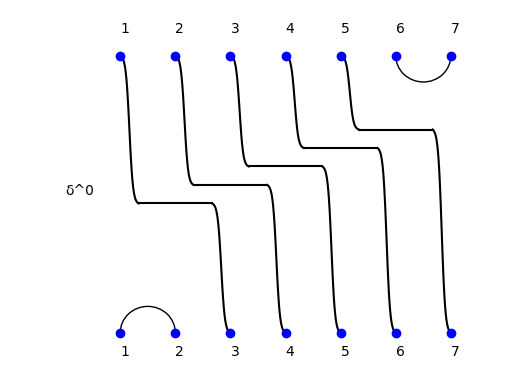

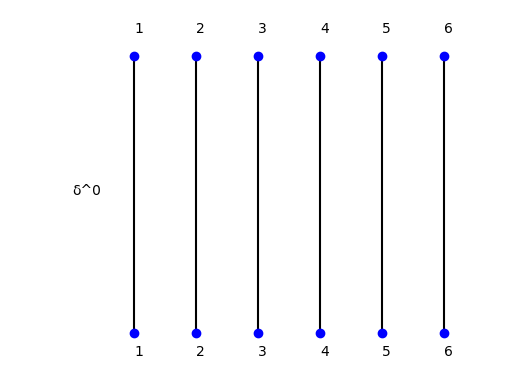

In [ ]:
# Lo que quiero testear y lo dibujo
generadores = [6, 5, 4, 3, 2, 1]
D = Multiplication(7, generadores)
D.draw()

heap = D.Factorization_Book()
Multiplication(5, heap[::-1]).draw()

heap = D.Factorization_Article()
Multiplication(5, heap[:]).draw()